<a href="https://colab.research.google.com/github/theill95/HFF/blob/main/Assignment3_TSLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd

# Read the data into a DataFrame
tweets_df = pd.read_csv('/content/drive/MyDrive/elonmusk.csv')

# Convert the 'Datetime' column to datetime format
tweets_df['Datetime'] = pd.to_datetime(tweets_df['Datetime'])

# Sort by ascending time
tweets_df = tweets_df.sort_values(by='Datetime')


In [17]:
import re

# Remove URLs, mentions, hashtags, and special characters from the 'Text' column
tweets_df['cleaned_text'] = tweets_df['Text'].apply(lambda x: re.sub(r'(https?://\S+)|(@\S+)|(#\S+)|[^a-zA-Z\s]', '', x))

# Convert text to lowercase
tweets_df['cleaned_text'] = tweets_df['cleaned_text'].str.lower()

tweets_df.tail()

,Datetime,Tweet Id,Text,Username,cleaned_text
4,2023-06-28 18:05:58+00:00,1674116945808068608,@BillyM2k Best protip ever,elonmusk,best protip ever
3,2023-06-29 01:19:59+00:00,1674226170488057856,Improved longform posts,elonmusk,improved longform posts
2,2023-06-29 03:46:37+00:00,1674263071337111552,@paulg Generational trauma. An example of why ...,elonmusk,generational trauma an example of why forgive...
1,2023-06-29 15:53:52+00:00,1674446089179766789,@TitterDaily True,elonmusk,true
0,2023-06-29 16:20:19+00:00,1674452749378002945,@mwseibel Yup,elonmusk,yup


In [3]:
!pip install finvader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [5]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
import pandas as pd
from finvader import finvader

# Assuming you've loaded tweets_df
def compute_finVADER_sentiment(text):
    return finvader(text, use_sentibignomics=True, use_henry=True, indicator='compound')

# Use cleaned_text for sentiment analysis
tweets_df['finVADER_sentiment'] = tweets_df['cleaned_text'].apply(compute_finVADER_sentiment)

# Convert Datetime to just date
tweets_df['Date'] = pd.to_datetime(tweets_df['Datetime']).dt.date

# Group by Date and sum the sentiment scores
daily_sentiment = tweets_df.groupby('Date')['finVADER_sentiment'].sum().reset_index()

# Load TSLA stock data, assume it's in a CSV format with 'Date' and 'Price' columns
stock_df = pd.read_csv('/content/drive/MyDrive/TSLA_daily.csv')

# Ensure the 'Date' column in stock_df is in the same format as the 'Date' column in daily_sentiment
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date

# Merge the two dataframes on 'Date'
merged_df = pd.merge(daily_sentiment, stock_df, on='Date', how='outer')

# Fill NaN sentiment values with 0 (days when there are no tweets)
merged_df['finVADER_sentiment'] = merged_df['finVADER_sentiment'].fillna(0)

# Convert the summed compound scores to categorical labels for easier interpretation
merged_df['finVADER_sentiment_label'] = merged_df['finVADER_sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Neutral' if x == 0 else 'Negative'))

print(merged_df)



            Date  finVADER_sentiment        Open        High         Low  \
0     2010-06-04              0.1027         NaN         NaN         NaN   
1     2011-12-01             -0.2505    2.171333    2.266000    2.132000   
2     2011-12-03             -0.1431         NaN         NaN         NaN   
3     2011-12-04              0.2876         NaN         NaN         NaN   
4     2011-12-21              1.0652    1.860667    1.871333    1.735333   
...          ...                 ...         ...         ...         ...   
4135  2023-08-04              0.0000  260.970001  264.769989  253.110001   
4136  2023-08-07              0.0000  251.449997  253.649994  242.759995   
4137  2023-08-08              0.0000  247.449997  250.919998  245.009995   
4138  2023-08-09              0.0000  250.869995  251.100006  241.899994   
4139  2023-08-10              0.0000  245.399994  251.800003  243.000000   

           Close   Adj Close       Volume finVADER_sentiment_label  
0            NaN  

In [19]:
# Create a column for the cumulative sentiment that needs to be propagated to the next trading day
merged_df['cumulative_sentiment'] = 0.0
merged_df['Price'] = merged_df['Adj Close']

cumulative_sentiment = 0.0
for index, row in merged_df.iterrows():
    # If it's a non-trading day (i.e., Close is NaN)
    if pd.isna(row['Price']):
        cumulative_sentiment += row['finVADER_sentiment']
        merged_df.at[index, 'finVADER_sentiment'] = 0  # Setting the sentiment to 0 as it's carried forward
    else:
        # Add the cumulative sentiment to the current day and reset
        merged_df.at[index, 'finVADER_sentiment'] += cumulative_sentiment
        cumulative_sentiment = 0.0

# Remove rows where 'Close' is NaN (non-trading days)
merged_df = merged_df.dropna(subset=['Price'])

In [20]:
merged_df.describe()

,finVADER_sentiment,Open,High,Low,Close,Adj Close,Volume,cumulative_sentiment,Price
count,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3.302000e+03,3302.0,3302.000000
mean,0.660580,65.422746,66.884593,63.837238,65.397959,65.397959,9.614876e+07,0.0,65.397959
std,1.360365,98.585431,100.822919,96.097294,98.491353,98.491353,8.107213e+07,0.0,98.491353
min,-1.941800,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06,0.0,1.053333
25%,0.000000,9.951500,10.150833,9.730833,9.865500,9.865500,4.472700e+07,0.0,9.865500
50%,0.000000,16.661668,16.898666,16.408334,16.666999,16.666999,7.927275e+07,0.0,16.666999
75%,0.849950,53.583334,54.901167,52.302666,53.359333,53.359333,1.226449e+08,0.0,53.359333
max,18.382500,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08,0.0,409.970001


In [21]:
# 1. Lagged Sentiment (1-6 days)
for i in range(1, 7): # Using 6 lags to capture a week's worth of delayed effects.
    merged_df[f'lagged_sentiment_{i}'] = merged_df['finVADER_sentiment'].shift(i)

# 2. Rolling Average Sentiment (3d, 7d, 31d)
for window in [3, 7, 31]:
    merged_df[f'rolling_avg_sentiment_{window}d'] = merged_df['finVADER_sentiment'].rolling(window=window).mean()

# 3. Sentiment Volatility (3d, 7d, 31d)
for window in [3, 7, 31]:
    merged_df[f'sentiment_volatility_{window}d'] = merged_df['finVADER_sentiment'].rolling(window=window).std()

# Dropping NaN rows generated due to rolling operations and lagged values
merged_df.dropna(inplace=True)

In [23]:
columns_to_drop = ['Open', 'High', 'Low', 'Volume', 'Close', 'Adj Close', 'cumulative_sentiment']
merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')  # Using errors='ignore' in case any column doesn't exist to prevent errors.
merged_df = merged_df.rename(columns={'finVADER_sentiment': 'sentiment'})
merged_df['Returns'] = merged_df['Price'].pct_change()
merged_df.dropna(subset=['Returns'], inplace=True)
merged_df.describe()

,sentiment,Price,lagged_sentiment_1,lagged_sentiment_2,lagged_sentiment_3,lagged_sentiment_4,lagged_sentiment_5,lagged_sentiment_6,rolling_avg_sentiment_3d,rolling_avg_sentiment_7d,rolling_avg_sentiment_31d,sentiment_volatility_3d,sentiment_volatility_7d,sentiment_volatility_31d,Returns
count,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000,3270.000000
mean,0.664727,66.018377,0.664727,0.664838,0.665158,0.665202,0.665071,0.665076,0.664764,0.664971,0.665568,0.641663,0.723332,0.792615,0.003929
std,1.365528,98.771318,1.365528,1.365489,1.365456,1.365437,1.365521,1.365518,0.990867,0.863477,0.765353,0.955177,0.884374,0.832431,0.055232
min,-1.941800,1.053333,-1.941800,-1.941800,-1.941800,-1.941800,-1.941800,-1.941800,-0.395933,-0.289043,0.000000,0.000000,0.000000,0.000000,-0.993815
25%,0.000000,10.760833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017771
50%,0.000000,16.751334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.211333,0.325236,0.422621,0.290389,0.491733,0.698720,0.001970
75%,0.864175,54.338500,0.864175,0.864175,0.865475,0.865475,0.865475,0.865475,1.030533,1.092768,1.158546,0.964138,1.180686,1.317833,0.022808
max,18.382500,409.970001,18.382500,18.382500,18.382500,18.382500,18.382500,18.382500,7.964233,6.473443,3.961606,10.213686,6.639416,4.202591,1.064614


In [24]:
from sklearn.model_selection import train_test_split

# Assuming merged_df is your main DataFrame
X = merged_df.drop(columns=['Returns', 'Price'])  # Drop target and non-feature columns
y = merged_df['Returns']

# Define the portion to reserve for testing
test_size = 0.10

# Separate out the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

# Split the remaining data between training and validation
# Here, I'm using 75% for training and the remaining 25% for validation from the temp data.
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, shuffle=False)

In [26]:
from sklearn.preprocessing import OrdinalEncoder

# Drop the 'Date' column
X_train = X_train.drop(columns=['Date'])
X_val = X_val.drop(columns=['Date'])
X_test = X_test.drop(columns=['Date'])

# Encode the 'finVADER_sentiment_label' column
encoder = OrdinalEncoder(categories=[['Negative', 'Neutral', 'Positive']])
X_train['finVADER_sentiment_label'] = encoder.fit_transform(X_train[['finVADER_sentiment_label']])
X_val['finVADER_sentiment_label'] = encoder.transform(X_val[['finVADER_sentiment_label']])
X_test['finVADER_sentiment_label'] = encoder.transform(X_test[['finVADER_sentiment_label']])


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


# Hyperparameters grid
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(2, 10), # increased the upper bound
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5),
    'min_child_weight': randint(1, 10), # adding this can help in controlling overfitting
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100], # L1 regularization term
    'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100] # L2 regularization term
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Random search
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=500, # Increase this for a longer search
    scoring='neg_mean_squared_error', # Or any other appropriate metric
    n_jobs=-1, # Use all CPU cores
    cv=5,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# The best model
best_xgb = random_search.best_estimator_




In [37]:
import numpy as np
print(f"Best parameters found: {random_search.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(np.abs(random_search.best_score_))}")

Best parameters found: {'colsample_bytree': 0.8729872627743591, 'gamma': 0.20425914646795845, 'learning_rate': 0.2898814201299864, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 467, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 0.5332481336833887}
Lowest RMSE found: 0.04769263682597008


In [28]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 3.9 MB/s eta 0:00:00


In [40]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Predicting the mean
mean_return = y_train.mean()
y_pred_mean = np.full(y_test.shape, mean_return)
rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))

# 2. Predicting the previous day's return
# Assuming the data is sorted in ascending chronological order
y_pred_prev = np.roll(y_test, shift=1)
y_pred_prev[0] = mean_return  # for the first day, we can use the mean return
rmse_prev = np.sqrt(mean_squared_error(y_test, y_pred_prev))

print(f"RMSE for predicting the mean: {rmse_mean:.4f}")
print(f"RMSE for predicting the previous day's return: {rmse_prev:.4f}")



RMSE for predicting the mean: 0.1070
RMSE for predicting the previous day's return: 0.1508


In [53]:
transaction_cost = 3/100000

def simulate_trading(predictions, actual_returns, pos_thresh, neg_thresh, N, profit_target, stop_loss, f, transaction_cost, initial_capital=10000):
    capital = initial_capital
    position = None  # 'long', 'short' or None
    entry_price = 0
    days_in_trade = 0
    trade_history = []
    capital_history = [initial_capital]  # to store capital at each time step for Sharpe ratio calculation

    for i in range(len(predictions)):
        if position:
            current_return = actual_returns.iloc[i]  # Use iloc for integer-based access
            trade_profit = entry_price * current_return
            days_in_trade += 1

            # Close out long positions based on criteria
            if position == 'long' and (trade_profit >= profit_target * entry_price or trade_profit <= stop_loss * entry_price or days_in_trade >= N):
                capital += entry_price + trade_profit - (entry_price * transaction_cost)  # apply transaction cost
                trade_history.append({'Type': 'long', 'Duration': days_in_trade, 'Profit': trade_profit})
                position = None
                days_in_trade = 0

            # Close out short positions based on criteria
            elif position == 'short' and (trade_profit <= -profit_target * entry_price or trade_profit >= -stop_loss * entry_price or days_in_trade >= N):
                capital += entry_price - trade_profit - (entry_price * transaction_cost)  # apply transaction cost
                trade_history.append({'Type': 'short', 'Duration': days_in_trade, 'Profit': -trade_profit})
                position = None
                days_in_trade = 0

        if not position:
            if predictions[i] > pos_thresh:
                position = 'long'
                entry_price = capital * f
                capital -= entry_price + (entry_price * transaction_cost)  # apply transaction cost

            elif predictions[i] < neg_thresh:
                position = 'short'
                entry_price = capital * f
                capital -= entry_price + (entry_price * transaction_cost)  # apply transaction cost

        capital_history.append(capital)

    # Compute Sharpe ratio
    daily_returns = [capital_history[i+1] / capital_history[i] - 1 for i in range(len(capital_history)-1)]
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) if np.std(daily_returns) != 0 else 0  # avoid division by zero

    return capital, trade_history, sharpe_ratio






In [46]:
!pip install bayesian-optimization


In [55]:
from bayes_opt import BayesianOptimization

# Updated objective function to optimize for both capital and Sharpe ratio
def objective(pos_thresh, neg_thresh, N, profit_target, stop_loss, f):
    # Get the final capital, trade history, and sharpe ratio from the updated function
    final_capital, trade_history, sharpe_ratio = simulate_trading(y_pred_val, y_val, pos_thresh, neg_thresh, int(N), profit_target, stop_loss, f, transaction_cost=3/100000)

    # You can adjust the weights (0.5) depending on which metric you prioritize more
    # Here, we're directly using the Sharpe ratio returned by the simulate_trading function
    return final_capital

# Define the hyperparameter bounds
param_bounds = {
    'pos_thresh': (0.001, 0.1),
    'neg_thresh': (-0.1, -0.001),
    'N': (1, 15),
    'profit_target': (0.001, 0.2),
    'stop_loss': (-0.2, -0.001),
    'f': (0.001, 0.2)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, verbose=2, random_state=42)

# Run Bayesian Optimization
optimizer.maximize(init_points=30, n_iter=150)  # Start with 30 random points, then 150 iterations of Bayesian optimization

print(optimizer.max)  # Prints the best parameters and the associated score.




|   iter    |  target   |     N     |     f     | neg_th... | pos_th... | profit... | stop_loss |
-------------------------------------------------------------------------------------------------
| 1         | 1e+04     | 6.244     | 0.1902    | -0.02753  | 0.06027   | 0.03205   | -0.169    |
| 2         | 1e+04     | 1.813     | 0.1734    | -0.04049  | 0.0711    | 0.005096  | -0.006988 |
| 3         | 1e+04     | 12.65     | 0.04326   | -0.082    | 0.01916   | 0.06154   | -0.09557  |
| 4         | 1e+04     | 7.047     | 0.05895   | -0.03943  | 0.01481   | 0.05914   | -0.1271   |
| 5         | 1e+04     | 7.385     | 0.1573    | -0.08023  | 0.05191   | 0.1189    | -0.1908   |
| 6         | 1e+04     | 9.506     | 0.03493   | -0.09356  | 0.09494   | 0.1932    | -0.03913  |
| 7         | 1e+04     | 5.265     | 0.02044   | -0.03226  | 0.04458   | 0.02529   | -0.1015   |
| 8         | 1e+04     | 1.481     | 0.182     | -0.07438  | 0.06659   | 0.06303   | -0.09651  |
| 9         | 1e+04 

In [56]:
y_pred_test = best_xgb.predict(X_test)


In [58]:
def simulate_trading(predictions, actual_returns, pos_thresh, neg_thresh, N, profit_target, stop_loss, f):
    capital = 10000
    capital_history = [capital]
    trade_history = []

    for idx, pred in enumerate(predictions):
        if idx < N:  # Skip the initial periods as per given parameter N
            continue
        if pred > pos_thresh:  # We enter a long trade
            trade_return = min(profit_target, max(stop_loss, actual_returns.iloc[idx])) * f
            capital += capital * trade_return
            trade_history.append(trade_return)
        elif pred < neg_thresh:  # We enter a short trade
            trade_return = min(profit_target, max(stop_loss, -actual_returns.iloc[idx])) * f
            capital += capital * trade_return
            trade_history.append(trade_return)

        capital_history.append(capital)

    return capital, trade_history, capital_history

# Use the function with the provided parameters
params = {
    'N': 8.507126769997406,
    'f': 0.19792481542554133,
    'neg_thresh': -0.034305219695068084,
    'pos_thresh': 0.0013573786052642773,
    'profit_target': 0.10052145991675282,
    'stop_loss': -0.14126980171079534
}

final_capital, trade_history, capital_history = simulate_trading(y_pred_test, y_test,
                                                                params['pos_thresh'],
                                                                params['neg_thresh'],
                                                                int(params['N']),
                                                                params['profit_target'],
                                                                params['stop_loss'],
                                                                params['f'])


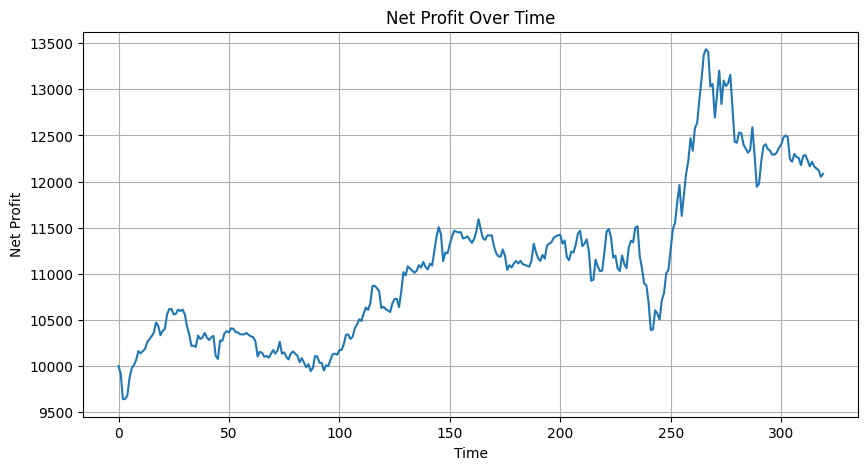

Profit Factor: 1.1774099001687184
Number of Trades: 319
Sharpe Ratio: 0.05656270578923495
Max Equity Drawdown: 11.09%


In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(10,5))
plt.plot(capital_history)
plt.xlabel("Time")
plt.ylabel("Net Profit")
plt.title("Net Profit Over Time")
plt.grid(True)
plt.show()

# Compute Relevant Statistics
returns = [capital_history[i] - capital_history[i - 1] for i in range(1, len(capital_history))]
gross_profit = sum([r for r in returns if r > 0])
gross_loss = sum([-r for r in returns if r < 0])

profit_factor = gross_profit / gross_loss if gross_loss != 0 else float('inf')
num_trades = len(trade_history)
sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) != 0 else -np.inf

# Computing Max Equity Drawdown
peak = capital_history[0]
max_drawdown = 0
for capital in capital_history:
    if capital > peak:
        peak = capital
    drawdown = (peak - capital) / peak
    if drawdown > max_drawdown:
        max_drawdown = drawdown

print(f"Profit Factor: {profit_factor}")
print(f"Number of Trades: {num_trades}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Equity Drawdown: {max_drawdown * 100:.2f}%")


In [61]:
num_profitable_trades = sum(1 for r in trade_history if r > 0)
hit_ratio = num_profitable_trades / num_trades * 100  # as a percentage
net_profit = capital_history[-1] - capital_history[0]
print(f"Hit Ratio: {hit_ratio:.2f}%")
print(f"Net Profit: {net_profit}")








Hit Ratio: 52.98%
Net Profit: 2083.0113922229193
